In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
import json
import os

In [ ]:
# ----------------------------- Load and Preprocess Dataset ----------------------------- #

# Load CSV
# Replace with your path if needed
df = pd.read_csv("/content/customer_support_tickets.csv")
df = df.rename(columns={'Ticket Description': 'text', 'Ticket Type': 'label'})
df = df.dropna(subset=['text', 'label'])
df = df[df['text'].str.len() > 5]
df = df[df['text'].str.len() < df['text'].str.len().quantile(0.95)]
df['text'].fillna("no description", inplace=True)

# Simulated metadata columns
np.random.seed(42)
df['customer_age_days'] = np.random.randint(30, 2000, size=len(df))
df['product_category'] = np.random.choice(['Electronics', 'Clothing', 'Books'], size=len(df))
df['ticket_hour'] = np.random.randint(0, 24, size=len(df))

# Sub-labels for 'Product inquiry'
df['sub_label'] = df.apply(lambda row: np.random.choice(['Availability', 'Warranty', 'Specification'])
                            if row['label'] == 'Product inquiry' else 'None', axis=1)

/tmp/ipython-input-6-1302021300.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text'].fillna("no description", inplace=True)


In [ ]:
# ----------------------------- NLTK Setup ----------------------------- #

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# ----------------------------- Vectorization ----------------------------- #

# TF-IDF for text
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['text'])

# One-hot encoding for metadata
ohe = OneHotEncoder(sparse_output=True)
X_meta = ohe.fit_transform(df[['product_category', 'ticket_hour']])

# Combine
X_combined = hstack([X_text, X_meta])
y_main = df['label']


In [ ]:
# ----------------------------- Train-Test Split ----------------------------- #

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_main, stratify=y_main, random_state=42)

In [ ]:
# ----------------------------- Main Model Training ----------------------------- #

main_model = LogisticRegression(max_iter=1000, class_weight='balanced')
main_model.fit(X_train, y_train)
y_pred = main_model.predict(X_test)
print("Main Classification Report:\n", classification_report(y_test, y_pred))

Main Classification Report:
                       precision    recall  f1-score   support

     Billing inquiry       0.18      0.19      0.19       385
Cancellation request       0.17      0.17      0.17       401
     Product inquiry       0.21      0.22      0.21       386
      Refund request       0.15      0.15      0.15       417
     Technical issue       0.19      0.19      0.19       416

            accuracy                           0.18      2005
           macro avg       0.18      0.18      0.18      2005
        weighted avg       0.18      0.18      0.18      2005



In [ ]:
import matplotlib.pyplot as plt

def plot_top_tfidf_features(class_label, top_n=10):
    idx = list(main_model.classes_).index(class_label)
    coefs = main_model.coef_[idx]
    top_indices = np.argsort(coefs)[-top_n:]
    features = np.array(tfidf.get_feature_names_out())[top_indices]
    plt.figure(figsize=(8, 6))
    plt.barh(features, coefs[top_indices])
    plt.title(f"Top {top_n} features for '{class_label}'")
    plt.xlabel("Coefficient value")
    plt.show()

In [ ]:
# ----------------------------- Sub-Model for Product Inquiry ----------------------------- #

df_sub = df[df['label'] == 'Product inquiry']
X_sub = tfidf.transform(df_sub['text'])
y_sub = df_sub['sub_label']
sub_model = LogisticRegression(max_iter=1000)
sub_model.fit(X_sub, y_sub)


LogisticRegression(max_iter=1000)

In [ ]:
# ----------------------------- Nearest Neighbors Setup ----------------------------- #

nn = NearestNeighbors(n_neighbors=3, metric='cosine')
nn.fit(X_text)

NearestNeighbors(metric='cosine', n_neighbors=3)

In [ ]:
# ----------------------------- Context Handling ----------------------------- #

def context_handler(prev_msgs, new_msg):
    return " ".join(prev_msgs[-2:] + [new_msg])

In [ ]:
# ----------------------------- Auto Response Generator ----------------------------- #

AUTO_RESPONSES = {
    "Product inquiry → Warranty": "Your product warranty lasts for 12 months. Please check your account for purchase details.",
    "Product inquiry → Availability": "Let me check availability. Could you please share the product name or model?",
    "Product inquiry → Specification": "Sure! Please specify which product specifications you are looking for.",
    "Complaint": "We're sorry to hear that. Your issue has been noted and will be escalated.",
    "Technical issue": "Please describe the issue you’re facing with the product. We’ll assist you shortly.",
    "Billing issue": "We apologize for the inconvenience. Please share your order number to verify the billing details.",
    # Add more label/sub-label mappings here
}

def generate_auto_response(prediction):
    return AUTO_RESPONSES.get(prediction, "Thank you for reaching out. Our team will get back to you shortly.")


In [ ]:
# ----------------------------- Prediction & Auto Reply ----------------------------- #

def predict_ticket(text, prev_msgs=[], simulated_meta=['Electronics', 14], threshold=0.6):
    # Combine context from previous messages with the current user input
    context_text = context_handler(prev_msgs, text)

    # Clean the combined text for consistent formatting
    cleaned = clean_text(context_text)

    # Vectorize the cleaned text using TF-IDF
    vec_text = tfidf.transform([cleaned])

    # Prepare and encode simulated metadata (product_category, ticket_hour)
    meta_df = pd.DataFrame([simulated_meta], columns=['product_category', 'ticket_hour'])
    vec_meta = ohe.transform(meta_df)

    # Combine text features and metadata features
    vec_combined = hstack([vec_text, vec_meta])

    # Predict probabilities for each label
    probs = main_model.predict_proba(vec_combined)
    confidence = probs.max()  # Highest confidence score among predictions
    label = main_model.classes_[probs.argmax()]  # Class with highest confidence

    # Escalation Logic: If confidence is below threshold, escalate to human support
    if confidence < threshold:
        return "Escalate to human support", confidence

    # If label is 'Product inquiry', use sub-model for further classification
    if label == 'Product inquiry':
        sub_label = sub_model.predict(vec_text)[0]
        return f"{label} → {sub_label}", confidence

    # Return final label and confidence
    return label, confidence


In [ ]:
# ----------------------------- Similar Ticket Retrieval ----------------------------- #

def find_similar_tickets(new_text):
    vec = tfidf.transform([clean_text(new_text)])
    distances, indices = nn.kneighbors(vec)
    return df.iloc[indices[0]][['text', 'label']].to_dict(orient='records')

In [ ]:
# ----------------------------- Feedback System ----------------------------- #

feedback_log = []

def store_feedback(ticket_id, predicted, feedback):
    feedback_log.append({"ticket_id": ticket_id, "predicted_label": predicted, "feedback": feedback})

Prediction: Escalate to human support
Confidence: 0.26321125900822173

Similar tickets:
- {'text': 'im issue productpurchased please assist tried product working thing working product valid shipping address problem started occurring recent software update havent made change device', 'label': 'Refund request'}
- {'text': 'im issue productpurchased please assist apologize inconvenience frustration product product product product product product product product product product ive noticed sudden decrease battery life productpurchased used last much longer', 'label': 'Refund request'}
- {'text': 'im issue productpurchased please assist please explain product code xh category makersystem product product product product product product product im worried issue might hardwarerelated might require repair replacement', 'label': 'Product inquiry'}

Feedback Log: [{'ticket_id': 1001, 'predicted_label': 'Escalate to human support', 'feedback': 'positive'}]
Available Labels: ['Billing inquiry' 'Can

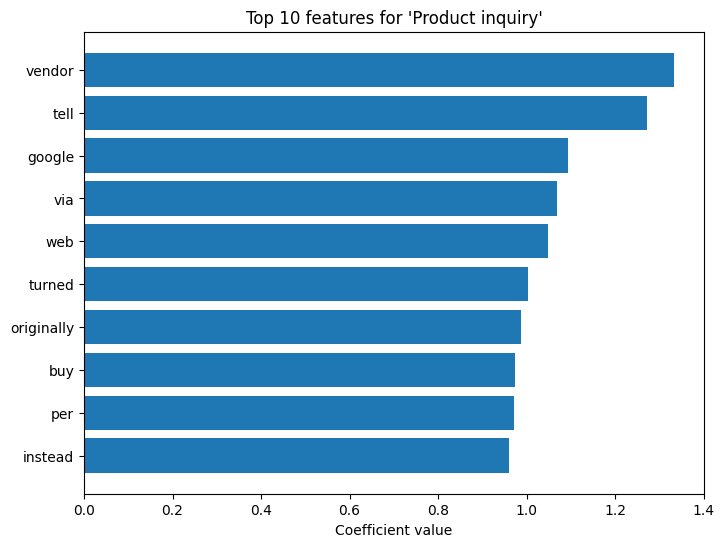

In [ ]:
# ----------------------------- Test Sample ----------------------------- #

if __name__ == "__main__":
    user_input = "Product is not working."
    prediction, conf = predict_ticket(user_input)
    print("Prediction:", prediction)
    print("Confidence:", conf)

    print("\nSimilar tickets:")
    for sim in find_similar_tickets(user_input):
        print("-", sim)

    store_feedback(1001, prediction, "positive")
    print("\nFeedback Log:", feedback_log)

    print("Available Labels:", main_model.classes_)

    # Visualize important features for 'Complaint' class
    plot_top_tfidf_features('Product inquiry', top_n=10)



In [ ]:
class SupportChatbot:
    def __init__(self, main_model, sub_model, tfidf, ohe, df):
        self.main_model = main_model
        self.sub_model = sub_model
        self.tfidf = tfidf
        self.ohe = ohe
        self.df = df
        self.chat_history = []  # stores dicts like {"role": "user"/"bot", "message": "..."}
        self.feedback_log = []
        self.nn = NearestNeighbors(n_neighbors=3, metric='cosine')
        self.nn.fit(tfidf.transform(df['text'].apply(clean_text)))

    def add_message(self, role, message):
        self.chat_history.append({"role": role, "message": message})

    def get_recent_context(self, n=2):
        user_messages = [msg["message"] for msg in self.chat_history if msg["role"] == "user"]
        return " ".join(user_messages[-n:])

    def predict(self, user_text, meta=['Electronics', 12]):
        context = self.get_recent_context() + " " + user_text
        cleaned = clean_text(context)
        vec_text = self.tfidf.transform([cleaned])
        meta_df = pd.DataFrame([meta], columns=['product_category', 'ticket_hour'])
        vec_meta = self.ohe.transform(meta_df)
        vec_combined = hstack([vec_text, vec_meta])

        probs = self.main_model.predict_proba(vec_combined)
        confidence = probs.max()
        label = self.main_model.classes_[probs.argmax()]

        # if confidence < 0.6:
        #     return "Escalate to human support", confidence

        if label == 'Product inquiry':
            sub_label = self.sub_model.predict(vec_text)[0]
            return f"{label} → {sub_label}", confidence

        return label, confidence

    def predict(self, user_text, meta=['Electronics', 12], threshold=0.6):
      context = self.get_recent_context() + " " + user_text
      cleaned = clean_text(context)
      vec_text = self.tfidf.transform([cleaned])
      meta_df = pd.DataFrame([meta], columns=['product_category', 'ticket_hour'])
      vec_meta = self.ohe.transform(meta_df)
      vec_combined = hstack([vec_text, vec_meta])

      # Get predicted probabilities
      probs = self.main_model.predict_proba(vec_combined)
      confidence = probs.max()
      label = self.main_model.classes_[probs.argmax()]

      # Escalate to human support if confidence is below threshold
      if confidence < threshold:
          return "Escalate to human support", confidence

      # Use sub-model if main label is 'Product inquiry'
      if label == 'Product inquiry':
          sub_label = self.sub_model.predict(vec_text)[0]
          return f"{label} → {sub_label}", confidence

      # Return the predicted label and confidence
      return label, confidence

    def find_similar(self, user_text):
        vec = self.tfidf.transform([clean_text(user_text)])
        distances, indices = self.nn.kneighbors(vec)
        return self.df.iloc[indices[0]][['text', 'label']].to_dict(orient='records')

    def store_feedback(self, ticket_id, prediction, feedback):
        self.feedback_log.append({
            'ticket_id': ticket_id,
            'predicted_label': prediction,
            'feedback': feedback
        })

    def handle_user(self, user_input, meta=['Electronics', 12]):
        self.add_message("user", user_input)

        prediction, confidence = self.predict(user_input, meta)
        similar = self.find_similar(user_input)

        bot_reply = f"Prediction: {prediction} (Confidence: {confidence:.2f})"
        self.add_message("bot", bot_reply)

        return prediction, confidence, similar

        # 🌟 Auto response based on prediction
        auto_reply = generate_auto_response(prediction)
        self.add_message("bot_response", auto_reply)

        return prediction, confidence, similar

    def get_chat_history(self):
        return self.chat_history


In [ ]:
bot = SupportChatbot(main_model, sub_model, tfidf, ohe, df)

# Simulating multi-turn chat
bot.handle_user("Hi, my product is not working")
bot.handle_user("I want to return it")
bot.handle_user("Also, what’s the warranty period?")
bot.handle_user("I want to check warranty")

# Show full conversation
for msg in bot.get_chat_history():
    print(f"{msg['role'].capitalize()}: {msg['message']}")


User: Hi, my product is not working
Bot: Prediction: Escalate to human support (Confidence: 0.27)
User: I want to return it
Bot: Prediction: Escalate to human support (Confidence: 0.30)
User: Also, what’s the warranty period?
Bot: Prediction: Escalate to human support (Confidence: 0.28)
User: I want to check warranty
Bot: Prediction: Escalate to human support (Confidence: 0.29)


In [ ]:
import pickle

pickle.dump(main_model, open("main_model.pkl", "wb"))
pickle.dump(sub_model, open("sub_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))
pickle.dump(ohe, open("ohe.pkl", "wb"))
pickle.dump(df, open("df.pkl", "wb"))


### Original

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack

# ----------------------------- Load and Preprocess Dataset ----------------------------- #

# Load CSV
# Replace with your path if needed
df = pd.read_csv("/content/customer_support_tickets.csv")
df = df.rename(columns={'Ticket Description': 'text', 'Ticket Type': 'label'})
df = df.dropna(subset=['text', 'label'])
df = df[df['text'].str.len() > 5]
df = df[df['text'].str.len() < df['text'].str.len().quantile(0.95)]
df['text'].fillna("no description", inplace=True)

# Simulated metadata columns
np.random.seed(42)
df['customer_age_days'] = np.random.randint(30, 2000, size=len(df))
df['product_category'] = np.random.choice(['Electronics', 'Clothing', 'Books'], size=len(df))
df['ticket_hour'] = np.random.randint(0, 24, size=len(df))

# Sub-labels for 'Product inquiry'
df['sub_label'] = df.apply(lambda row: np.random.choice(['Availability', 'Warranty', 'Specification'])
                            if row['label'] == 'Product inquiry' else 'None', axis=1)

# ----------------------------- NLTK Setup ----------------------------- #

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['text'] = df['text'].apply(clean_text)

# ----------------------------- Vectorization ----------------------------- #

# TF-IDF for text
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(df['text'])

# One-hot encoding for metadata
ohe = OneHotEncoder(sparse_output=True)
X_meta = ohe.fit_transform(df[['product_category', 'ticket_hour']])

# Combine
X_combined = hstack([X_text, X_meta])
y_main = df['label']

# ----------------------------- Train-Test Split ----------------------------- #

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_main, stratify=y_main, random_state=42)

# ----------------------------- Main Model Training ----------------------------- #

main_model = LogisticRegression(max_iter=1000, class_weight='balanced')
main_model.fit(X_train, y_train)
y_pred = main_model.predict(X_test)
print("Main Classification Report:\n", classification_report(y_test, y_pred))

# ----------------------------- Sub-Model for Product Inquiry ----------------------------- #

df_sub = df[df['label'] == 'Product inquiry']
X_sub = tfidf.transform(df_sub['text'])
y_sub = df_sub['sub_label']
sub_model = LogisticRegression(max_iter=1000)
sub_model.fit(X_sub, y_sub)

# ----------------------------- Nearest Neighbors Setup ----------------------------- #

nn = NearestNeighbors(n_neighbors=3, metric='cosine')
nn.fit(X_text)

# ----------------------------- Context Handling ----------------------------- #

def context_handler(prev_msgs, new_msg):
    return " ".join(prev_msgs[-2:] + [new_msg])

# ----------------------------- Prediction & Auto Reply ----------------------------- #

def predict_ticket(text, prev_msgs=[], simulated_meta=['Electronics', 14]):
    context_text = context_handler(prev_msgs, text)
    cleaned = clean_text(context_text)
    vec_text = tfidf.transform([cleaned])
    meta_df = pd.DataFrame([simulated_meta], columns=['product_category', 'ticket_hour'])
    vec_meta = ohe.transform(meta_df)
    vec_combined = hstack([vec_text, vec_meta])

    probs = main_model.predict_proba(vec_combined)
    confidence = probs.max()
    label = main_model.classes_[probs.argmax()]

    # if confidence < 0.6:
    #     return "Escalate to human support", confidence

    if label == 'Product inquiry':
        sub_label = sub_model.predict(vec_text)[0]
        return f"{label} → {sub_label}", confidence

    return label, confidence

# ----------------------------- Similar Ticket Retrieval ----------------------------- #

def find_similar_tickets(new_text):
    vec = tfidf.transform([clean_text(new_text)])
    distances, indices = nn.kneighbors(vec)
    return df.iloc[indices[0]][['text', 'label']].to_dict(orient='records')

# ----------------------------- Feedback System ----------------------------- #

feedback_log = []

def store_feedback(ticket_id, predicted, feedback):
    feedback_log.append({"ticket_id": ticket_id, "predicted_label": predicted, "feedback": feedback})

# ----------------------------- Test Sample ----------------------------- #

if __name__ == "__main__":
    user_input = "Product is not working."
    prediction, conf = predict_ticket(user_input)
    print("Prediction:", prediction)
    print("Confidence:", conf)

    print("\nSimilar tickets:")
    for sim in find_similar_tickets(user_input):
        print("-", sim)

    store_feedback(1001, prediction, "positive")
    print("\nFeedback Log:", feedback_log)

class SupportChatbot:
    def __init__(self, main_model, sub_model, tfidf, ohe, df):
        self.main_model = main_model
        self.sub_model = sub_model
        self.tfidf = tfidf
        self.ohe = ohe
        self.df = df
        self.chat_history = []  # stores dicts like {"role": "user"/"bot", "message": "..."}
        self.feedback_log = []
        self.nn = NearestNeighbors(n_neighbors=3, metric='cosine')
        self.nn.fit(tfidf.transform(df['text'].apply(clean_text)))

    def add_message(self, role, message):
        self.chat_history.append({"role": role, "message": message})

    def get_recent_context(self, n=2):
        user_messages = [msg["message"] for msg in self.chat_history if msg["role"] == "user"]
        return " ".join(user_messages[-n:])

    def predict(self, user_text, meta=['Electronics', 12]):
        context = self.get_recent_context() + " " + user_text
        cleaned = clean_text(context)
        vec_text = self.tfidf.transform([cleaned])
        meta_df = pd.DataFrame([meta], columns=['product_category', 'ticket_hour'])
        vec_meta = self.ohe.transform(meta_df)
        vec_combined = hstack([vec_text, vec_meta])

        probs = self.main_model.predict_proba(vec_combined)
        confidence = probs.max()
        label = self.main_model.classes_[probs.argmax()]

        # if confidence < 0.6:
        #     return "Escalate to human support", confidence

        if label == 'Product inquiry':
            sub_label = self.sub_model.predict(vec_text)[0]
            return f"{label} → {sub_label}", confidence

        return label, confidence

    def find_similar(self, user_text):
        vec = self.tfidf.transform([clean_text(user_text)])
        distances, indices = self.nn.kneighbors(vec)
        return self.df.iloc[indices[0]][['text', 'label']].to_dict(orient='records')

    def store_feedback(self, ticket_id, prediction, feedback):
        self.feedback_log.append({
            'ticket_id': ticket_id,
            'predicted_label': prediction,
            'feedback': feedback
        })

    def handle_user(self, user_input, meta=['Electronics', 12]):
        self.add_message("user", user_input)

        prediction, confidence = self.predict(user_input, meta)
        similar = self.find_similar(user_input)

        bot_reply = f"Prediction: {prediction} (Confidence: {confidence:.2f})"
        self.add_message("bot", bot_reply)

        return prediction, confidence, similar

    def get_chat_history(self):
        return self.chat_history

bot = SupportChatbot(main_model, sub_model, tfidf, ohe, df)

# Simulating multi-turn chat
bot.handle_user("Hi, my product is not working")
bot.handle_user("I want to return it")
bot.handle_user("Also, what’s the warranty period?")

# Show full conversation
for msg in bot.get_chat_history():
    print(f"{msg['role'].capitalize()}: {msg['message']}")



/tmp/ipython-input-2-332429057.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text'].fillna("no description", inplace=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Main Classification Report:
                       precision    recall  f1-score   support

     Billing inquiry       0.18      0.19      0.19       385
Cancellation request       0.17      0.17      0.17       401
     Product inquiry       0.21      0.22      0.21       386
      Refund request       0.15      0.15      0.15       417
     Technical issue       0.19      0.19      0.19       416

            accuracy                           0.18      2005
           macro avg       0.18      0.18      0.18      2005
        weighted avg       0.18      0.18      0.18      2005

Prediction: Technical issue
Confidence: 0.26321125900822173

Similar tickets:
- {'text': 'im issue productpurchased please assist tried product working thing working product valid shipping address problem started occurring recent software update havent made change device', 'label': 'Refund request'}
- {'text': 'im issue productpurchased please assist apologize inconvenience frustration product product produ

In [ ]:
import pickle

pickle.dump(main_model, open("main_model.pkl", "wb"))
pickle.dump(sub_model, open("sub_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))
pickle.dump(ohe, open("ohe.pkl", "wb"))
pickle.dump(df, open("df.pkl", "wb"))
